In [2]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\ProgramData\Anaconda3\python.exe
3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)


In [4]:
!pip3 install --upgrade tensorflow-gpu

In [5]:
import tensorflow as tf

In [13]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import imageio
import skimage.io
import skimage.transform
from pathlib import Path
from imageio import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
base_dir = 'D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'
os.listdir(base_dir)

['brain_image_dir',
 'ct_ich.yml',
 'ct_scans',
 'data',
 'hemorrhage_diagnosis_raw_ct.csv',
 'LICENSE.txt',
 'masks',
 'mask_dir',
 'Patients_CT',
 'Patient_demographics.csv',
 'Read_me.txt',
 'SHA256SUMS.txt',
 'split_raw_data.py',
 'train']

In [16]:
dem_path = base_dir + '\\Patient_demographics.csv'
df_dem = pd.read_csv(dem_path)
df_dem.shape

(85, 10)

In [17]:
path_seg = base_dir + '\\masks\\049.nii'
img_seg = nib.load(path_seg)
img_data_seg = img_seg.get_fdata()

In [18]:
df_dem.head()

,Patient Number,Age\n(years),Gender,Hemorrhage type based on the radiologists diagnosis,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Fracture (yes 1/no 0),Note1
0,NaN,NaN,NaN,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,NaN,NaN
1,49.0,35.000,Male,NaN,1,NaN,1,NaN,1.0,NaN
2,50.0,0.583,Female,NaN,1,NaN,NaN,NaN,1.0,NaN
3,51.0,5.000,Male,NaN,1,NaN,NaN,1,1.0,NaN
4,52.0,8.000,Male,NaN,NaN,NaN,1,NaN,1.0,NaN


In [19]:
df_dem['Gender'].value_counts()

Male      46
Female    36
36         1
46         1
Name: Gender, dtype: int64

In [51]:
diag_path = base_dir + '\\hemorrhage_diagnosis_raw_ct.csv'
df_diag = pd.read_csv(diag_path)
df_diag.shape

(2501, 9)

In [52]:
df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [22]:
df_diag['No_Hemorrhage'].value_counts()

1    2183
0     318
Name: No_Hemorrhage, dtype: int64

In [135]:
df_diag['PatientNumber'].nunique()

75

In [23]:
ct_path = 'D:\\AI_Database\\TBI\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\ct_scans'
ct_list = os.listdir(ct_path)
len(ct_list)

75

In [24]:
path = base_dir + '\\ct_scans\\049.nii'  
img = nib.load(path)

In [25]:
# here, we're storing the header attribute in a new variable, hdr, for easy of use
hdr = img.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 48
dim             : [  3 512 512  39   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.41210938  0.41210938  5.          0.          0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 2914
glmin           : -1024
descrip         : b'time=--------------.---;'
aux_file        : b';SIEMENS;Head_SAFIRE'
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.0
quatern_c       : 1.0
quatern_d       : -0.0

In [26]:
hdr.keys()

['sizeof_hdr',
 'data_type',
 'db_name',
 'extents',
 'session_error',
 'regular',
 'dim_info',
 'dim',
 'intent_p1',
 'intent_p2',
 'intent_p3',
 'intent_code',
 'datatype',
 'bitpix',
 'slice_start',
 'pixdim',
 'vox_offset',
 'scl_slope',
 'scl_inter',
 'slice_end',
 'slice_code',
 'xyzt_units',
 'cal_max',
 'cal_min',
 'slice_duration',
 'toffset',
 'glmax',
 'glmin',
 'descrip',
 'aux_file',
 'qform_code',
 'sform_code',
 'quatern_b',
 'quatern_c',
 'quatern_d',
 'qoffset_x',
 'qoffset_y',
 'qoffset_z',
 'srow_x',
 'srow_y',
 'srow_z',
 'intent_name',
 'magic']

In [27]:
hdr.get_xyzt_units()

('mm', 'unknown')

In [28]:
img_data = img.get_fdata()
print(type(img_data))  # it's a 3D numpy array!
print(img_data.shape)

<class 'numpy.memmap'>
(512, 512, 39)


In [29]:
print(img_data)

[[[-995. -993. -996. ... -994. -992. -990.]
  [-995. -995. -996. ... -995. -993. -993.]
  [-995. -996. -996. ... -995. -996. -994.]
  ...
  [-996. -996. -995. ... -992. -993. -992.]
  [-995. -996. -993. ... -991. -992. -992.]
  [-996. -996. -994. ... -991. -991. -992.]]

 [[-996. -994. -996. ... -995. -993. -991.]
  [-996. -995. -996. ... -995. -995. -993.]
  [-996. -996. -996. ... -995. -997. -994.]
  ...
  [-996. -996. -993. ... -992. -994. -992.]
  [-996. -996. -992. ... -991. -992. -993.]
  [-996. -996. -994. ... -990. -990. -992.]]

 [[-996. -996. -997. ... -995. -994. -992.]
  [-996. -996. -996. ... -995. -996. -993.]
  [-996. -996. -996. ... -996. -996. -994.]
  ...
  [-996. -996. -993. ... -992. -994. -993.]
  [-996. -996. -993. ... -990. -994. -994.]
  [-996. -996. -995. ... -990. -992. -993.]]

 ...

 [[-991. -994. -997. ... -998. -998. -996.]
  [-992. -995. -998. ... -998. -998. -997.]
  [-991. -996. -998. ... -998. -997. -998.]
  ...
  [-994. -997. -998. ... -990. -990. -99

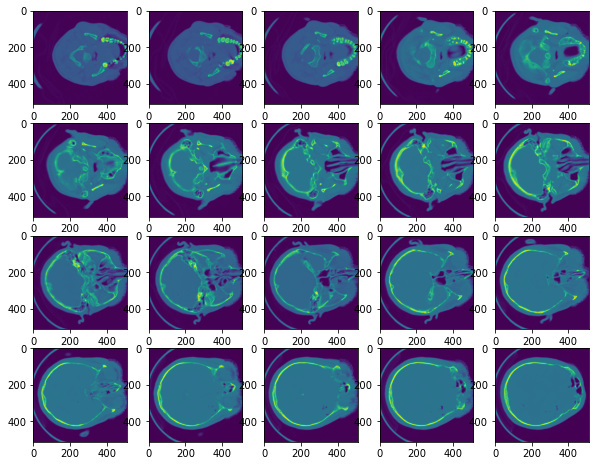

<Figure size 432x288 with 0 Axes>

In [71]:
for i in range(20):
    plt.subplot(5, 5, i + 1)
    plt.imshow(img_data[:,:, i])
    plt.gcf().set_size_inches(10, 10)
plt.show()
plt.savefig('all_raw.png', dpi=300)

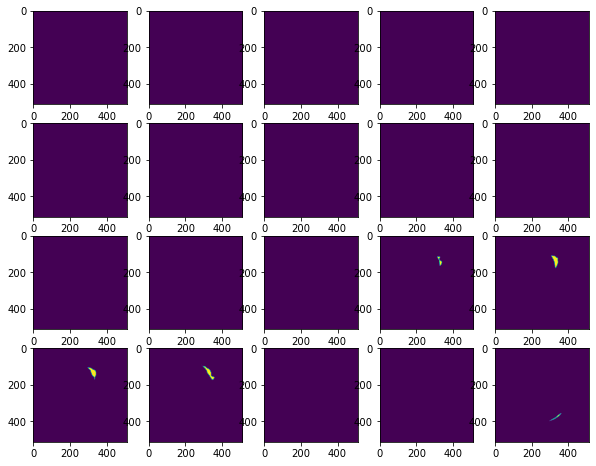

<Figure size 432x288 with 0 Axes>

In [72]:
for i in range(20):
    plt.subplot(5, 5,i + 1)
    plt.imshow(img_data_seg[:,:, i])
    plt.gcf().set_size_inches(10, 10)
plt.show()
plt.savefig('mask.png', dpi=300)

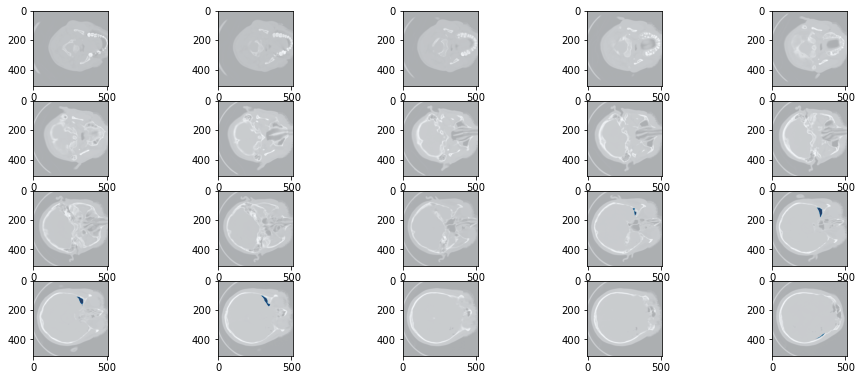

<Figure size 432x288 with 0 Axes>

In [70]:
plt.figure(figsize=(16, 8)) 

for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(img_data[:,:,i], cmap='gray')
    plt.imshow(img_data_seg[:,:,i], cmap='Blues', alpha=0.7)
plt.show()
plt.savefig('all.png', dpi=50)

In [159]:
df_diag.head(50)

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0
5,49,6,0,0,0,0,0,1,0
6,49,7,0,0,0,0,0,1,0
7,49,8,0,0,0,0,0,1,0
8,49,9,0,0,0,0,0,1,0
9,49,10,0,0,0,0,0,1,0


In [164]:
df_diag.tail(50)

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
2764,129,22,0,0,0,0,0,1,0
2765,129,23,0,0,0,0,0,1,0
2766,129,24,0,0,0,0,0,1,0
2767,129,25,0,0,0,0,0,1,0
2768,129,26,0,0,0,0,0,1,0
2769,129,27,0,0,0,0,0,1,0
2770,129,28,0,0,0,0,0,1,0
2771,129,29,0,0,0,0,0,1,0
2772,129,30,0,0,0,0,0,1,0
2773,129,31,0,0,0,0,0,1,0


In [53]:
def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

# create a new target column
df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

# drop the old target column
df_diag = df_diag.drop('No_Hemorrhage', axis=1)

print(df_diag.shape)

df_diag.head()

(2501, 9)


,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage
0,49,1,0,0,0,0,0,0,0
1,49,2,0,0,0,0,0,0,0
2,49,3,0,0,0,0,0,0,0
3,49,4,0,0,0,0,0,0,0
4,49,5,0,0,0,0,0,0,0


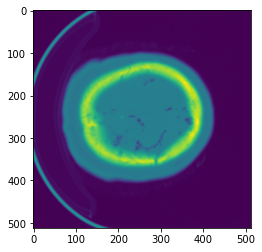

In [124]:
plt.imshow(img_data[:,:,30])

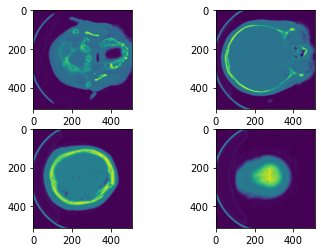

In [125]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_data[:,:,4])
axarr[0,1].imshow(img_data[:,:,16])
axarr[1,0].imshow(img_data[:,:,28])
axarr[1,1].imshow(img_data[:,:,33])

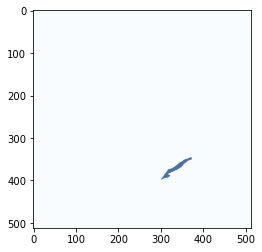

In [126]:
plt.imshow(img_data_seg[:,:,21], cmap='Blues', alpha=0.7)

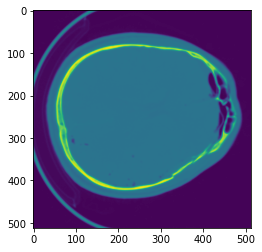

In [127]:
plt.imshow(img_data[:,:,21])

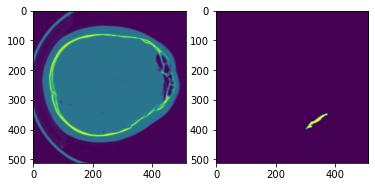

In [65]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_data[:,:,21])
axarr[1].imshow(img_data_seg[:,:,21])
plt.savefig('combo.png', dpi=300)

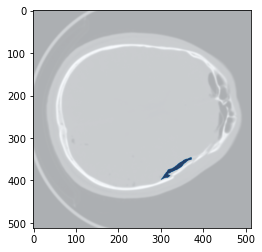

In [63]:
plt.imshow(img_data[:,:,21], cmap='gray')
plt.imshow(img_data_seg[:,:,21], cmap='Blues', alpha=0.7)
plt.savefig('output.png', dpi=300)

In [138]:
def window_ct (ct_scan, w_level=40, w_width=120):
    w_min = w_level - w_width / 2
    w_max = w_level + w_width / 2
    num_slices=ct_scan.shape[2]
    for s in range(num_slices):
        slice_s = ct_scan[:,:,s]
        slice_s = (slice_s - w_min)*(255/(w_max-w_min)) #or slice_s = (slice_s - (w_level-(w_width/2)))*(255/(w_width))
        slice_s[slice_s < 0]=0
        slice_s[slice_s > 255] = 255
        #slice_s=np.rot90(slice_s)
        ct_scan[:,:,s] = slice_s

    return ct_scan

In [165]:
numSubj = 82
new_size = (512, 512)
window_specs=[40,120] #Brain window
currentDir = Path(os.getcwd()) 
print(currentDir)
# Change the current working directory
os.chdir('D://Solayman//DataSets//computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1')
currentDir = Path(os.getcwd()) 
print(currentDir)
datasetDir = str(base_dir)

D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1


In [166]:
# Reading labels
hemorrhage_diagnosis_array = df_diag._get_values

In [167]:
# reading images

train_path = Path('data')
print(train_path)
image_path = train_path / 'image'
label_path = train_path / 'label'
if not train_path.exists():
    train_path.mkdir()
    image_path.mkdir()
    label_path.mkdir()

data


In [168]:
counterI = 0

for sNo in range(0+49, numSubj+49):
    if sNo>58 and sNo<66: #no raw data were available for these subjects
        next
    else:
        #Loading the CT scan
        ct_dir_subj = Path(datasetDir,'ct_scans', "{0:0=3d}.nii".format(sNo))
        ct_scan_nifti = nib.load(str(ct_dir_subj))
        ct_scan = ct_scan_nifti.get_data()
        ct_scan = window_ct(ct_scan, window_specs[0], window_specs[1])

        #Loading the masks
        masks_dir_subj = Path(datasetDir,'masks', "{0:0=3d}.nii".format(sNo))
        masks_nifti = nib.load(str(masks_dir_subj))
        masks = masks_nifti.get_data()
        idx = hemorrhage_diagnosis_array[:, 0] == sNo
        sliceNos = hemorrhage_diagnosis_array[idx, 1]
        NoHemorrhage = hemorrhage_diagnosis_array[idx, 7]
        if sliceNos.size!=ct_scan.shape[2]:
            print('Warning: the number of annotated slices does not equal the number of slices in NIFTI file!')

        for sliceI in range(0, sliceNos.size):
            # Saving the a given CT slice
            #x = imresize(ct_scan[:,:,sliceI], new_size)
            x = skimage.transform.resize(ct_scan[:,:,sliceI], new_size)
            #plt.imsave(image_path / (str(counterI) + '.png'), x)
            plt.imsave(image_path / (str(sNo)  + '_' + str(sliceNos[sliceI]) + '.png'), x)

            # Saving the segmentation for a given slice
            segment_path = Path(masks_dir_subj,str(sliceNos[sliceI]) + '_HGE_Seg.jpg')
            x = skimage.transform.resize(masks[:,:,sliceI], new_size)
            #plt.imsave(label_path / (str(counterI) + '.png'), x)
            plt.imsave(label_path /(str(sNo)  + '_' +  str(sliceNos[sliceI]) + '_HGE_Seg.png'), x)
            counterI = counterI+1

<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-168-389ca634c572>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprec

<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-168-389ca634c572>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprec

<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-168-389ca634c572>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprec

<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ct_scan = ct_scan_nifti.get_data()
<ipython-input-168-389ca634c572>:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  masks = masks_nifti.get_data()
<ipython-input-168-389ca634c572>:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprec

In [54]:
# Create new columns


def get_mask_fname(row):
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    

# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)




def new_mask_fname(row):
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)




def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname


# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    
# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)



df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
0,49,1,0,0,0,0,0,0,0,1_HGE_Seg.jpg,49_1_HGE_Seg.jpg,1.jpg,49_1.jpg
1,49,2,0,0,0,0,0,0,0,2_HGE_Seg.jpg,49_2_HGE_Seg.jpg,2.jpg,49_2.jpg
2,49,3,0,0,0,0,0,0,0,3_HGE_Seg.jpg,49_3_HGE_Seg.jpg,3.jpg,49_3.jpg
3,49,4,0,0,0,0,0,0,0,4_HGE_Seg.jpg,49_4_HGE_Seg.jpg,4.jpg,49_4.jpg
4,49,5,0,0,0,0,0,0,0,5_HGE_Seg.jpg,49_5_HGE_Seg.jpg,5.jpg,49_5.jpg


In [171]:
currentDir = Path(os.getcwd())
print(currentDir)

D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1


49_15.png
(512, 512, 4)


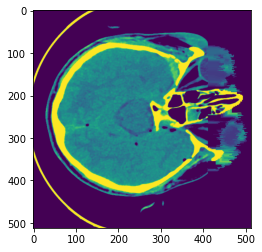

In [172]:
# brain image

index = 14
fname = df_diag.loc[index, 'new_image_fname']
print(fname)
path = 'D:\\Solayman\\DataSets\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\data\\image\\' + fname 
# read the image as a matrix
brain_image = plt.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

In [179]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_image_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)
               
    plt.tight_layout()
    plt.show()
    
    
def draw_category_masks(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_mask_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

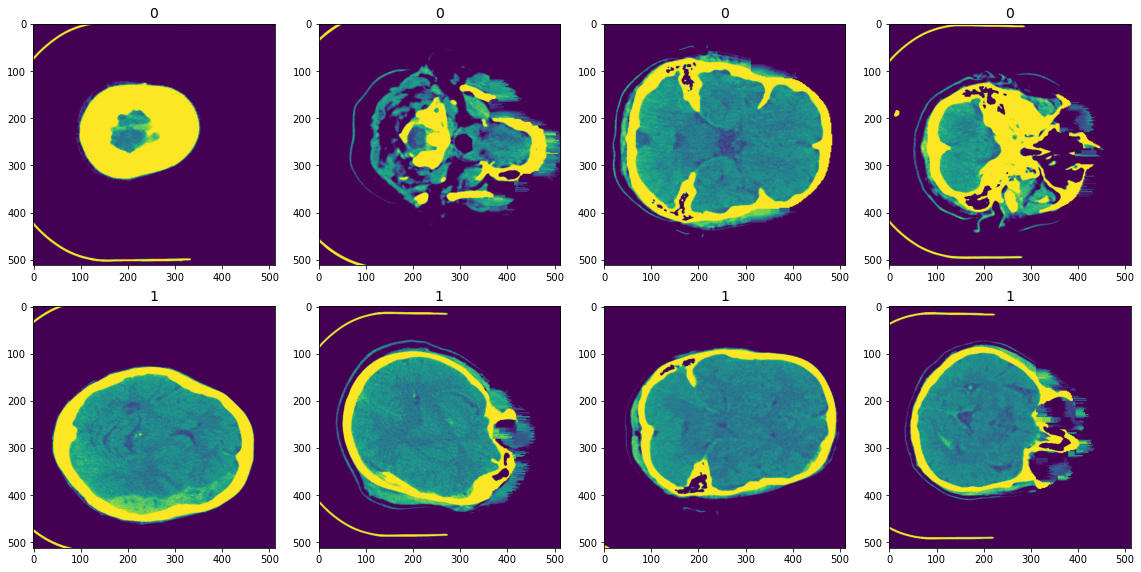

In [176]:
IMAGE_PATH = 'D:\\Solayman\\DataSets\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\data\\image\\' 
draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

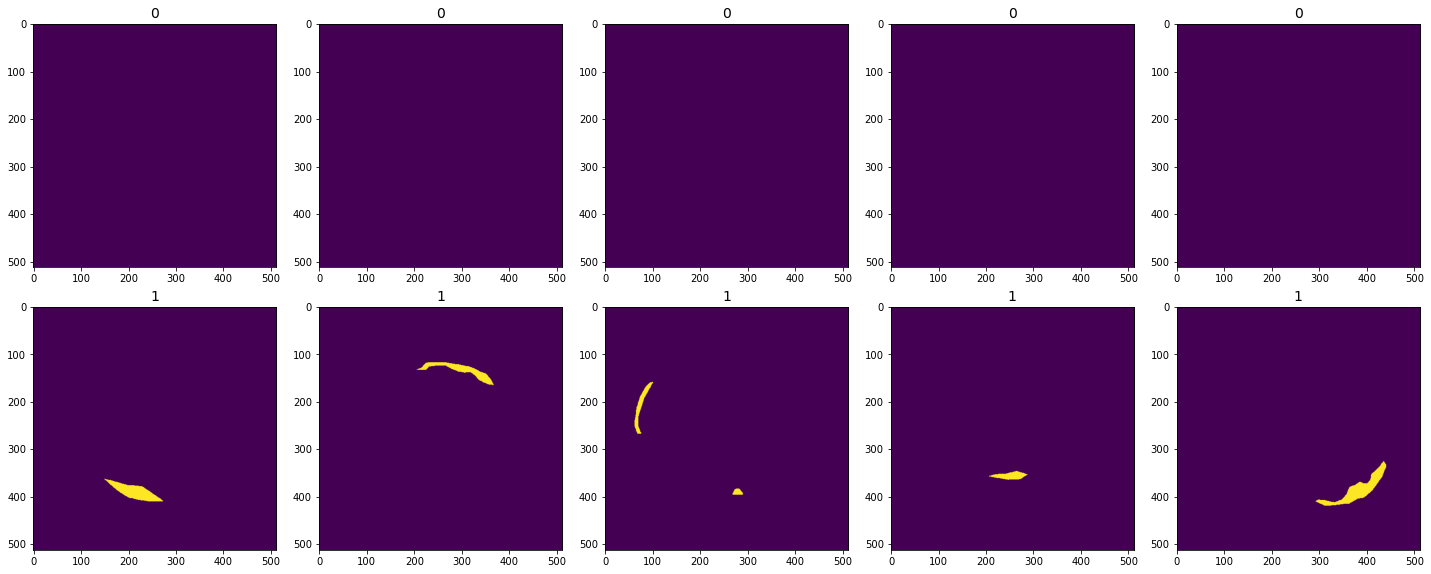

In [180]:
# Masks

IMAGE_PATH = 'D:\\Solayman\\DataSets\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\data\\label\\' 

draw_category_masks('Has_Hemorrhage',5, df_diag, IMAGE_PATH)

In [35]:
# Function to perform the augmentations

def augment_image_and_mask(augmentation, image, mask):
    
    """
 
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image, mask=mask)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix

In [36]:
# HOW TO DO MULTIPLE AUGMENTATIONS

import albumentations as albu

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])


# This how to call the function
# aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)

C:\ProgramData\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [183]:
print(df_diag.shape)

(2814, 13)


In [186]:
IMAGE_PATH = 'D:\\Solayman\\DataSets\\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\\data\\image' 
len(os.listdir(IMAGE_PATH))

2814

In [187]:
NUM_TEST_IMAGES = 10


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)



print(df_diag.shape)
print(df_test.shape)

(2794, 13)
(20, 13)


In [189]:
df_test.head(20)

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,mask_fname,new_mask_fname,image_fname,new_image_fname,Has_Hemorrhage
0,49,20,0,0,0,1,0,1,20_HGE_Seg.png,49_20_HGE_Seg.png,20.png,49_20.png,1
1,50,26,0,1,0,0,0,1,26_HGE_Seg.png,50_26_HGE_Seg.png,26.png,50_26.png,1
2,81,34,0,0,0,0,1,0,34_HGE_Seg.png,81_34_HGE_Seg.png,34.png,81_34.png,1
3,49,27,0,1,0,0,0,1,27_HGE_Seg.png,49_27_HGE_Seg.png,27.png,49_27.png,1
4,70,13,0,0,0,1,0,0,13_HGE_Seg.png,70_13_HGE_Seg.png,13.png,70_13.png,1
5,50,22,0,1,0,0,0,1,22_HGE_Seg.png,50_22_HGE_Seg.png,22.png,50_22.png,1
6,52,12,0,0,0,1,0,0,12_HGE_Seg.png,52_12_HGE_Seg.png,12.png,52_12.png,1
7,76,39,0,1,1,0,0,1,39_HGE_Seg.png,76_39_HGE_Seg.png,39.png,76_39.png,1
8,74,18,0,0,0,0,1,1,18_HGE_Seg.png,74_18_HGE_Seg.png,18.png,74_18.png,1
9,81,38,0,0,0,0,1,0,38_HGE_Seg.png,81_38_HGE_Seg.png,38.png,81_38.png,1


In [195]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)


(2374, 13)
(420, 13)


In [196]:
# Check the target distribution in the train set

df_train['Has_Hemorrhage'].value_counts()

0    2112
1     262
Name: Has_Hemorrhage, dtype: int64

In [197]:
# Check the target distribution in the val set

df_val['Has_Hemorrhage'].value_counts()

0    374
1     46
Name: Has_Hemorrhage, dtype: int64

In [199]:
print(currentDir)
# Change the current working directory
os.chdir('D://Solayman//DataSets//computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1//train')
currentDir = Path(os.getcwd()) 
print(currentDir)

D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\train


In [200]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [201]:
# check if the files were saved
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
from segmentation_models import  get_preprocessing # this line has an error in the docs

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

In [31]:
import cv2
IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10 # 10 with intracranial hem + 10 without intracranial hem

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 10

In [294]:
currentDir = Path(os.getcwd()) 
print(currentDir)
# Change the current working directory
os.chdir('D://Solayman//DataSets//computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1')
currentDir = Path(os.getcwd()) 
print(currentDir)
datasetDir = str(base_dir)

D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1


In [295]:
# create a new mask dir
mask_dir = 'mask_dir'
os.mkdir(mask_dir)

In [296]:
path = base_dir + '\Patients_CT'

folder_list = os.listdir(path)

len(folder_list)

82

In [297]:
# For non blank masks i.e. masks showing intracranial hemorrhage

import shutil

for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 1]
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # Source path to mask.
        # All masks are in the brain folder.
        path = base_dir + '\\Patients_CT\\' + folder_name + '\\brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(mask_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
# Check how many masks are in the new folder. (Should be 318)
len(os.listdir('mask_dir'))

318

In [301]:
# For blank masks i.e. masks without intracranial hemorrhage

blank_mask = np.zeros((IMAGE_HEIGHT_ORIG, IMAGE_WIDTH_ORIG))


for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    # filter by Has_Hemorrhage
    df = df[df['Has_Hemorrhage'] == 0]  # <-- for empty masks change filter here
    
    # get the list of mask file names
    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # set the destination where the file will be saved
        dst = os.path.join(mask_dir, new_fname)
      
        # save the image
        cv2.imwrite(dst, blank_mask)
        
# Check how many masks are in the new folder. (Should be 2500)
len(os.listdir('mask_dir'))

2501

In [298]:
# create a new mask dir
brain_image_dir = 'brain_image_dir'
os.mkdir(brain_image_dir)

In [299]:
for folder_name in folder_list:
    
    # convert the folder name to integer
    patient_num = int(folder_name)
    
    # filter by patient number
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    # get the list of image file names
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        # add the patient number to the file name
        new_fname = str(patient_num) + '_' + fname
        
        # source path to image
        path = base_dir + '\\Patients_CT\\' + folder_name + '\\brain'
        src = os.path.join(path, fname)
        # destination path to mask
        dst = os.path.join(brain_image_dir, new_fname)
        # copy the mask from the source to the destination
        shutil.copyfile(src, dst)
        
        

# Check how many images are in the new folder (Should be 2500)
len(os.listdir('brain_image_dir'))

2501

In [55]:
NUM_TEST_IMAGES = 10


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)



print(df_diag.shape)
print(df_test.shape)

(2481, 13)
(20, 13)


In [58]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2108, 13)
(373, 13)


In [308]:
currentDir = Path(os.getcwd()) 
print(currentDir)
# Change the current working directory
os.chdir('D://Solayman//DataSets//computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1//train')
currentDir = Path(os.getcwd()) 
print(currentDir)

D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1\train


In [309]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [37]:
currentDir = Path(os.getcwd()) 
print(currentDir)
# Change the current working directory
os.chdir('D://Solayman//DataSets//computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1')
currentDir = Path(os.getcwd()) 
print(currentDir)

D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1
D:\Solayman\DataSets\computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1


In [114]:
# We are only using brain images for training.
# These are originally single channel images but cv2 will read them with 3 channels.

def train_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('train/df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
              
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create Y_train
            # ===============
                
 

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augment the image and mask
            # ===========================
            
                aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                # insert the image into Y_train
                Y_train[i] = aug_mask
                
                              
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, Y_train

In [115]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=10)

# run the generator
X_train, Y_train = next(train_gen)

print(X_train.shape)
print(Y_train.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


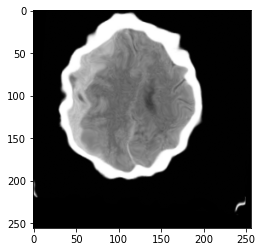

In [116]:
# print the first image in X_train

img = X_train[7,:,:,:]
plt.imshow(img)

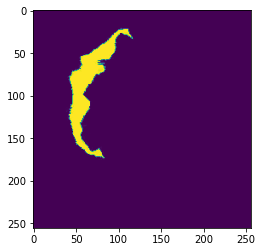

In [117]:
# print the mask in Y_train

msk = Y_train[7,:,:,0]
plt.imshow(msk)

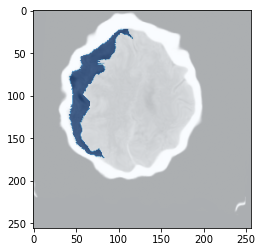

In [118]:
plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

In [119]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('train/df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32) 

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                
            
            # Normalize the images
            X_val = X_val/255
            
            yield X_val, Y_val

In [120]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [121]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('train/df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
            
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_test[i] = image
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_test[j] = mask
            
            #tf.cast(Y_test, tf.float32)
            # Normalize the images
            X_test = X_test/255
            
            yield X_test, Y_test

In [122]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=15)

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(15, 256, 256, 3)
(15, 256, 256, 1)


In [123]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


from keras.optimizers import Adam
from keras.losses import binary_crossentropy

from keras.initializers import he_normal 

import tensorflow as tf

In [124]:
from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing # this line has an error in the docs

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss
#from segmentation_models.metrics import dice_score

from segmentation_models.utils import set_trainable

In [125]:
#preprocess = get_preprocessing('resnet101') # for resnet, img = (img-110.0)/1.0

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

#model.summary()

In [126]:
# initialize
test_gen = test_generator(batch_size=len(df_test))

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(20, 256, 256, 3)
(20, 256, 256, 1)


In [127]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [128]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss=dice_loss,
    metrics=[iou_score],
)


filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')


log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]




In [129]:
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5, 
                              validation_data=val_gen, validation_steps=val_steps,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/40


<ipython-input-129-1f628fbedbfd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=40,


211/211 [==============================] - ETA: 0s - loss: 0.5476 - iou_score: 0.4675 
Epoch 1: val_loss improved from inf to 0.49205, saving model to model.h5
211/211 [==============================] - 2621s 12s/step - loss: 0.5476 - iou_score: 0.4675 - val_loss: 0.4921 - val_iou_score: 0.5728 - lr: 1.0000e-04
Epoch 2/40
211/211 [==============================] - ETA: 0s - loss: 0.3806 - iou_score: 0.8482 
Epoch 2: val_loss improved from 0.49205 to 0.28517, saving model to model.h5
211/211 [==============================] - 2554s 12s/step - loss: 0.3806 - iou_score: 0.8482 - val_loss: 0.2852 - val_iou_score: 1.1441 - lr: 1.0000e-04
Epoch 3/40
211/211 [==============================] - ETA: 0s - loss: 0.2415 - iou_score: 1.4379 
Epoch 3: val_loss did not improve from 0.28517
211/211 [==============================] - 2575s 12s/step - loss: 0.2415 - iou_score: 1.4379 - val_loss: 0.2941 - val_iou_score: 1.8117 - lr: 1.0000e-04
Epoch 4/40
 54/211 [======>.......................] - ETA: 31

KeyboardInterrupt: 

In [72]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss=dice_loss,
    metrics=[iou_score],
)



filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]

history = Model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

TypeError: fit_generator() missing 1 required positional argument: 'generator'

In [330]:
pip install tensorflow==1.15 --ignore-installed --user

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==1.15 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow==1.15


In [203]:
pip install tensorflow --ignore-installed --user

  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached protobuf-3.19.4-cp38-cp38-win_amd64.whl (895 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
Processing c:\users\semon\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501\termcolor-1.1.0-py3-none-any.whl
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.8-py3-none-any.whl (39 kB)
  Using cached requests_oauthlib-1.3.1-py2.py

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [73]:
! pip install segmentation-models

In [77]:
! pip install albumentations